In [1]:
import talk.config as con

% matplotlib inline

con.config_mosek()
con.config_configManager()
con.config_matplotlib()

Set MOSEKLM_LICENSE_FILE environment variable
Update ConfigManager


Constructing estimators 
------------------------
https://en.wikipedia.org/wiki/Autoregressive_model

#### Thomas Schmelzer

A very common estimator is based on AR models (autoregressive)

$$R_T = \sum_{i=1}^n w_i r_{T-i}$$

Predict the (unknown) return $R_T$ using the last $n$ previous returns. You may want to use volatility adjusted returns, etc.
 
How to pick the $n$ free parameters in $\mathbf{w}$? (Partial) autocorrelations? 



In [26]:
import pandas as pd

def convolution(ts, weights):
    from statsmodels.tsa.filters.filtertools import convolution_filter
    return convolution_filter(ts, weights, nsides=1)

r = pd.Series([1.0, -2.0, 1.0, 1.0, 1.5, 0.0, 2.0])
weights = [2.0, 1.0]
# trendfollowing == positive weights
x=pd.DataFrame()
x["r"] = pd.Series(r)
x["pred"] = pd.Series(convolution(r, weights)).shift(1)
print(x)
print(x.corr())

     r  pred
0  1.0   NaN
1 -2.0   NaN
2  1.0  -3.0
3  1.0   0.0
4  1.5   3.0
5  0.0   4.0
6  2.0   1.5
             r      pred
r     1.000000 -0.190159
pred -0.190159  1.000000


In [27]:
# mean-reversion == negative weights
weights = [-2.0, -1.0]
x=pd.DataFrame()
x["r"] = pd.Series(r)
x["pred"] = pd.Series(convolution(r, weights)).shift(1)
print(x)
print(x.corr())

     r  pred
0  1.0   NaN
1 -2.0   NaN
2  1.0   3.0
3  1.0   0.0
4  1.5  -3.0
5  0.0  -4.0
6  2.0  -1.5
             r      pred
r     1.000000  0.190159
pred  0.190159  1.000000


Looking only at the last two returns might be a bit ...

Is it a good idea to have $n=100$ free parameters?



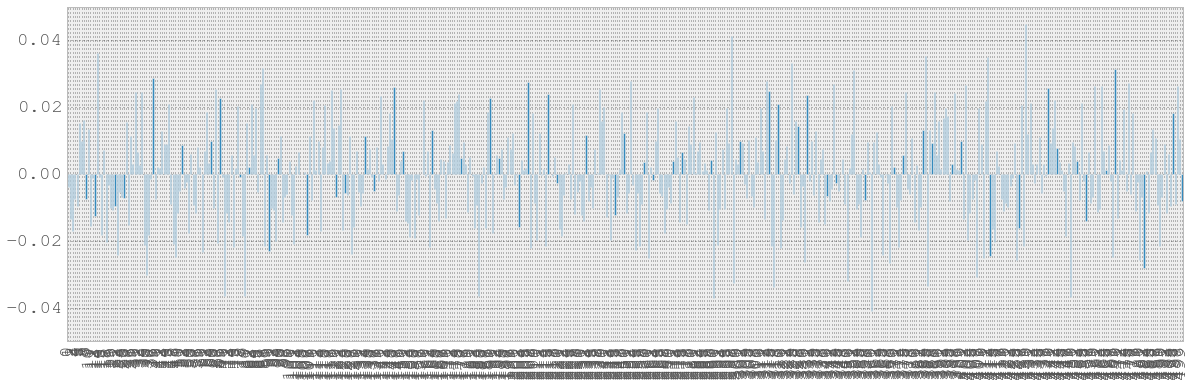

             r      pred
r     1.000000  0.311651
pred  0.311651  1.000000


In [45]:
import numpy as np
import pandas as pd
r = np.random.randn(5000)
import statsmodels.tsa.stattools as sts
weights = sts.pacf(r, nlags=500)
?? sts.pacf
p = pd.Series(data=weights[1:])
p.plot(kind="bar")
plt.show()
x = pd.DataFrame()
x["r"] = pd.Series(r)
x["pred"] = pd.Series(convolution(r, weights[1:])).shift(1)
print(x.corr())

Bias
----

We assume the weights are exponentially decaying, e.g.

$$w_i = \frac{1}{S}\lambda^i$$

where $S$ is a suitable scaling constant and $\lambda = 1-1/N$. Note that $N \neq n$.

**Everything** that is **not** an exponentially weighted moving average is **wrong**.


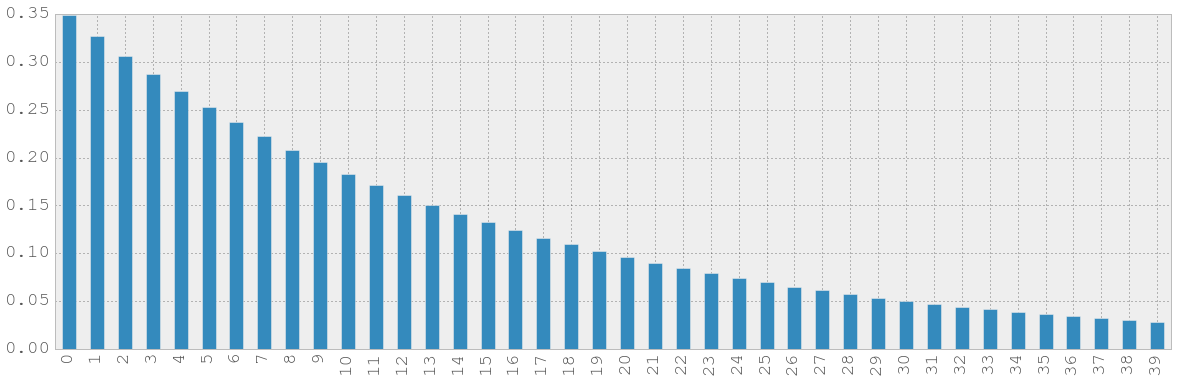

In [39]:
import numpy as np

def exp_weights(m, n=100):
    x = np.power(1.0 - 1.0/m, range(1,n+1))
    S = np.linalg.norm(x)
    return x/S

f = exp_weights(m=16,n=40)
p = pd.Series(f)
p.plot(kind="bar")
plt.show()

In [42]:
import numpy as np
r = pd.Series(np.random.randn(1000))

def mean_variation(ts):
    return ts.diff().abs().mean()

periods = [2,4,6,8,12,16,24,32,48,64,96,192]
# matrix of weights
W = pd.DataFrame({period : exp_weights(m=period, n=200) for period in periods}) 

# each column of A is a convoluted return time series
A = pd.DataFrame({period : convolution(r, W[period]).shift(1) for period in periods})  

d = A.apply(mean_variation)
print(d)
D = np.diag(d)

2      0.778537
4      0.551977
6      0.451525
8      0.391118
12     0.319599
16     0.277157
24     0.226575
32     0.196252
48     0.160107
64     0.138572
96     0.113893
192    0.088703
dtype: float64


In [44]:
A = A.dropna(axis=0)
r = r[A.index].dropna()
print(A.std())

2      1.004897
4      1.027275
6      1.033974
8      1.034480
12     1.027834
16     1.017134
24     0.992924
32     0.969020
48     0.924893
64     0.886498
96     0.828718
192    0.751146
dtype: float64


(Naive) regression
-------------------

\begin{align}
\mathbf{w}^{*}=\arg\min_{\mathbf{w} \in \mathbb{R}^m}& \rVert{\mathbf{A}\mathbf{w} - \mathbf{r}}\lVert_2 
\end{align}

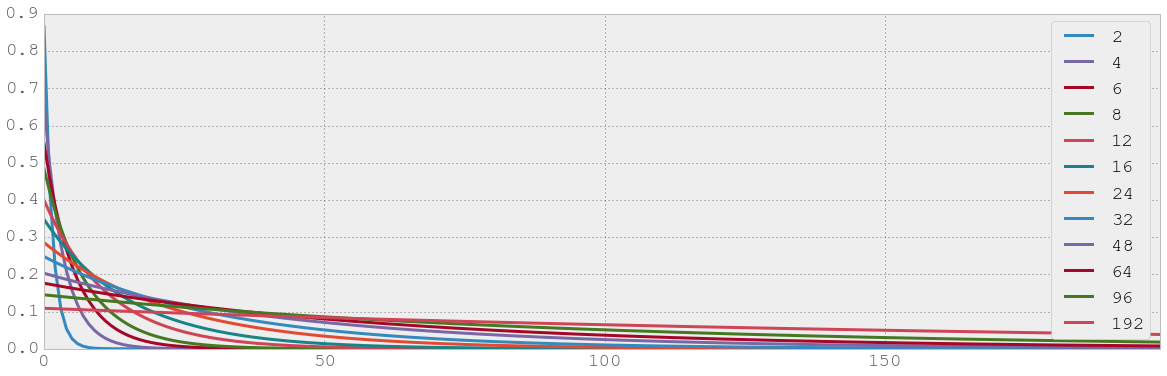

In [63]:
from mosek.fusion import *
import numpy as np
import pandas as pd

r = pd.Series(np.random.randn(5000))
periods = [2,4,6,8,12,16,24,32,48,64,96,192]
# matrix of weights
W = pd.DataFrame({period : exp_weights(m=period, n=200) for period in periods}) 
W.plot()

In [64]:
# each column of A is a convoluted return time series
A = pd.DataFrame({period : convolution(r, W[period]).shift(1) for period in periods})  

A = A.dropna(axis=0)
r = r[A.index].dropna()
print(A.std())

from numpy.linalg import lstsq
# sometimes you don't need to use MOSEK :-)
print(lstsq(A.values, r.values)[0])

2      1.004888
4      1.004473
6      1.002743
8      1.000427
12     0.996705
16     0.995005
24     0.996180
32     1.000388
48     1.010599
64     1.019644
96     1.032337
192    1.047662
dtype: float64
[  1.42895860e-01  -4.90190503e+00   3.77452491e+01  -9.87181961e+01
   2.78204477e+02  -4.99770229e+02   9.54172544e+02  -1.30429287e+03
   1.51321136e+03  -1.23811778e+03   4.19478168e+02  -5.71543005e+01]


In [65]:
# but you could use Mosek: 
def __residual(model, A, x, b, name="2-norm"):
    # residual = A*x - b
    residual = Expr.sub(Expr.mul(DenseMatrix(A),x), Expr.constTerm(b))
    # add variable to model for the 2-norm of the residual
    residual_2norm = model.variable(name, 1, Domain.greaterThan(0.0))
    # add the quadratic cone
    model.constraint(Expr.vstack(residual_2norm,residual), Domain.inQCone())
    return residual_2norm

def ar(A, r):
    with Model('lasso') as model:
        n = int(A.shape[1])
        # introduce the variable for the var
        x = model.variable("x", n, Domain.unbounded())
        # minimization of the conditional value at risk
        model.objective(ObjectiveSense.Minimize, __residual(model, A, x, r))
        model.solve()

        return x.level()
    
# same result as with lstsq
print(ar(A.values,r.values))

[0.14325603681370266, -4.911336101021502, 37.82170999070693, -98.9296950227565, 278.8479840536481, -500.98313888256786, 956.6266941107488, -1307.765623521129, 1517.4053647936641, -1241.6274916228097, 420.6960114223563, -57.32433337341404]


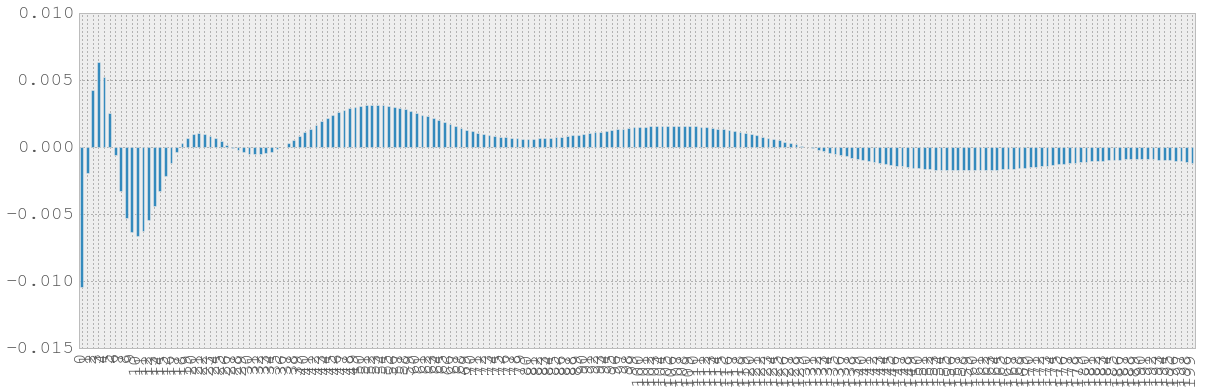

In [66]:
x = pd.Series(index=periods, data=ar(A.values,r.values))
xxxx = (W*x).sum(axis=1)
xxxx.plot(kind="bar")
plt.show()    

### Mean variation

$$MV(\mathbf{x}) = \frac{1}{n}\sum{\lvert x_i - x_{i-1}\rvert}=\frac{1}{n}\rVert{\Delta \mathbf{x}}\lVert_1$$

Find a linear combination of those predictors. Very bad idea to solve

$$\mathbf{w}^{*}=\arg\min_{\mathbf{w} \in \mathbb{R}^m} \lVert{\mathbf{Aw}-\mathbf{r}}\rVert_2 + \lambda \rVert{\mathbf{Dw}}\lVert_1$$


\begin{align}\mathbf{w}^{*}=\arg\min_{\mathbf{w} \in \mathbb{R}^m}& \rVert{\mathbf{A}\mathbf{w}-\mathbf{r}}\lVert_2 + \lambda \rVert{\mathbf{w}}\lVert_2\\
\text{s.t. } &\Sigma\,w_i=1\\
            &\mathbf{w}\geq 0
\end{align}